# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [1]:
# блок импорта
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Подготовка моделей
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Модели (в нашем случае актуальна только линейная регрессия)
from sklearn.linear_model import LinearRegression

# Метрики
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import stats as st

In [2]:
# Определим сразу random_state для всего проекта
RS = 12345

In [3]:
# Создадим датафреймы
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
# Посмотрим на данные
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
# Посмотрим информацию по нашему фрейму
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### Промежуточный вывод

    1. Все датафреймы содержат одинаковый объём данных
    2. Пропущенных значений или несоответствия типов нигде нет
    3. Столбец id для предсказаний нам нужно будет исключить (в целом, можно было бы и удалить, но эти значения могут потом понадобится для анализа другим аналитикам или заинтересованным лицам, чтобы понять, например, значения каких именно скважин мы предсказывали)
    4. Адекватность значений признаков мы не можем оценить т.к. контекст нам неизвестен
    
    Далее нам нужно понять, насколько наши признаки различаются в своих значениях, чтобы один признак не имел большой власти над другим.

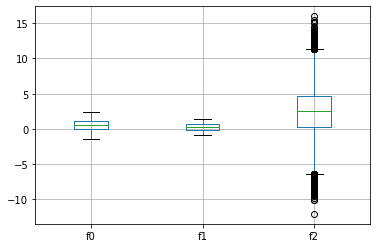

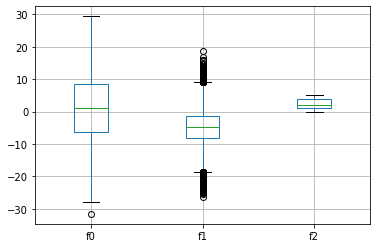

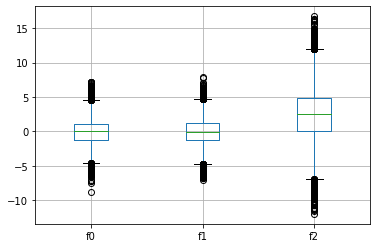

In [10]:
# Посмотрим на примере одного датасета, как сильно различаются параметры
fields = ['f0', 'f1', 'f2']

for df in [df1, df2, df3]:
    df.boxplot(column=fields)
    plt.show()

### Промежуточный вывод

    1. Сами значения внутри фрейма различаются в амплитуде (нужно скалировать)
    2. Хоть выбросы и составляют порядка 5%, удалять их страшно, т.к. непонятно, что за признаки. А значит есть вероятность, что это "не баг, а фича". Однако при стандартизации они также будут влиять на результат, поэтому все же решил удалить (заодно подровнять вес признаков в дальнейшем)
    3. К тому же RMSE чувствительна к отклонениям и об этом тоже следует помнить

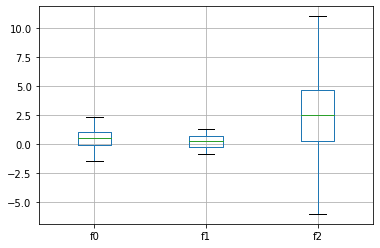

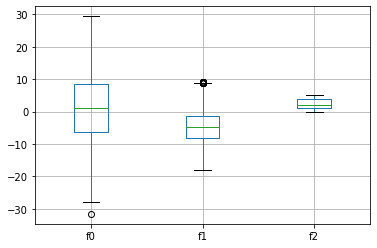

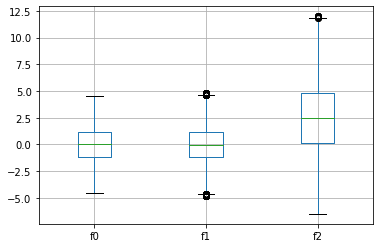

In [11]:
# Удалим выбросы
df1 = df1[(df1['f2'] <= 11) & (df1['f2'] >= -6)]
df2 = df2[(df2['f1'] <= 9) & (df2['f1'] >= -18)]
df3 = df3[(df3['f0'] <= 4.5) & (df3['f0'] >= -4.5) & (df3['f1'] <= 4.8) & (df3['f1'] >= -4.8) & (df3['f2'] <= 12) & (df3['f2'] >= -6.5)]

# Проверим, что все ок
for df in [df1, df2, df3]:
    df.boxplot(column=fields)
    plt.show()

In [12]:
# Проверим, что не удалили много лишнего
for df in [df1, df2, df3]:
    # сбросим индексы
    df.reset_index(inplace=True)
    print(df.count())

index      99249
id         99249
f0         99249
f1         99249
f2         99249
product    99249
dtype: int64
index      99194
id         99194
f0         99194
f1         99194
f2         99194
product    99194
dtype: int64
index      97789
id         97789
f0         97789
f1         97789
f2         97789
product    97789
dtype: int64


### Вывод

- Мы ознакомились с нашими данными
- Убедились в отсутствии пропусков
- Избавились от выбросов
- Определились с тем, что признаки нужно будет стандартизировать

# 2. Обучение и проверка модели

In [13]:
# Разобьем выборку в пропорции 75-25
def split_df(df):
    target = df['product']
    features = df[['f0', 'f1', 'f2']]

    return train_test_split(features, target, test_size=0.25, random_state=RS)

features_train_1, features_valid_1, target_train_1, target_valid_1 = split_df(df1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_df(df2)
features_train_3, features_valid_3, target_train_3, target_valid_3 = split_df(df3)

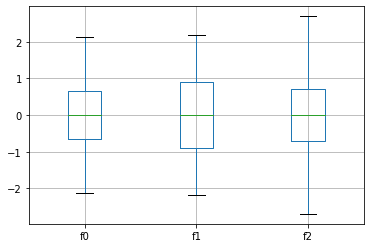

In [14]:
# Стандартизируем признаки
def scale_features(features_train, features_valid):
    # У каждого фрейма должен быть свой скалер
    scaler = StandardScaler()
    numeric = ['f0', 'f1', 'f2']
    scaler.fit(features_train[numeric])
    pd.set_option('mode.chained_assignment', None)
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid

features_train_1, features_valid_1 = scale_features(features_train_1, features_valid_1)
features_train_2, features_valid_2 = scale_features(features_train_2, features_valid_2)
features_train_3, features_valid_3 = scale_features(features_train_3, features_valid_3)

# Проверим, что все ок
features_train_1.boxplot(column=['f0', 'f1', 'f2'])

In [15]:
# обучим модель и проверим ее на валидационной выборке
# в нашем случае по условию задачи это может быть только линейная регрессия, поэтому удобно будет написать функцию
# также сразу напишем функцию для рассчета rmse для удобства

def rmse(target, predicted):
    mse = mean_squared_error(target, predicted)
    return mse ** 0.5

# для интереса напишем функцию, котора будет выводить все результаты нашей модели (MSE, RMSE, R2)
def full_score_info(target, predicted):
    mse = mean_squared_error(target, predicted)
    rmse_val = rmse(target, predicted)
    r2 = r2_score(target, predicted)
    mae = mean_absolute_error(target, predicted)
    predicted_mean = predicted.mean()
    
    print('|{: >9}|{: >9}|{: >9}|{: >9}|{: >15}|'.format('RMSE', 'MSE', 'R2', 'MAE', 'Predicted mean'))
    print('|{: >9.6f}|{: >9.4f}|{: >9.7f}|{: >9.6f}|{: >15.6f}|'.format(rmse_val, mse, r2, mae, predicted_mean))
    
    # по условиям задачи дальше нам интересно сохранять средние предсказанные значения и rmse
    return rmse, predicted_mean

def train_the_model(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    predicted_mean, rmse = full_score_info(target_valid, predicted_valid)
    
    return predicted_mean, rmse, predicted_valid

In [16]:
#Выведем информацию по каждой модели, а итоговые предсказания для удобства сразу переведем в Series

print('Model for region 1');
predicted_mean_1, rmse_1, predicted_valid_1 = train_the_model(features_train_1, target_train_1, features_valid_1, target_valid_1)
predicted_valid_df_1 = pd.Series(data=predicted_valid_1, index=target_valid_1.index)
print('Model for region 2');
predicted_mean_2, rmse_2, predicted_valid_2 = train_the_model(features_train_2, target_train_2, features_valid_2, target_valid_2)
predicted_valid_df_2 = pd.Series(data=predicted_valid_2, index=target_valid_2.index)
print('Model for region 3');
predicted_mean_3, rmse_3, predicted_valid_3 = train_the_model(features_train_3, target_train_3, features_valid_3, target_valid_3)
predicted_valid_df_3 = pd.Series(data=predicted_valid_3, index=target_valid_3.index)

Model for region 1
|     RMSE|      MSE|       R2|      MAE| Predicted mean|
|37.669866|1419.0188|0.2755680|31.083365|      92.485878|
Model for region 2
|     RMSE|      MSE|       R2|      MAE| Predicted mean|
| 0.888268|   0.7890|0.9996214| 0.715224|      69.072767|
Model for region 3
|     RMSE|      MSE|       R2|      MAE| Predicted mean|
|40.184815|1614.8193|0.1914792|32.925614|      95.003775|


### Промежуточный вывод

    1. Что любопытно, RMSE модели для 1го и 3го региона очень похожи, как и предсказанные значения, однако сами значения имеют довольно приличное отклонение
    2. В то же время, для второго региона мы имеем гораздо лучшую точность, но и меньшее предсказание средних запасов

# 3. Подготовка к расчёту прибыли

In [17]:
# Внесем основные параметры задачи
POINTS_TO_EXPLORE_COUNT = 500 # сколько точек исследуют при разведке региона
POINTS_FOR_PROFIT_COUNT = 200 # по какому количеству точек считают прибыль (лучшие точки)
DEVELOPMENT_BUDGET = 10 * (10 ** 9) # бюджет на разработку (в рублях)
BARREL_PROFIT = 450 # стоимость одного барреля (в рублях)
PRODUCT_PROFIT = BARREL_PROFIT * 1000 # стоимость единицы продукта (в рублях)
LOSS_PROBABILITY_LIMIT = 2.5 # предельная вероятность убытков на регион (в процентах)

In [18]:
# Рассчитаем достаточный объём сырья для безубыточной разработки (региона)
MIN_PRODUCT_FOR_BREAK_EVEN_DEV_REGION = DEVELOPMENT_BUDGET / PRODUCT_PROFIT
MIN_PRODUCT_FOR_BREAK_EVEN_DEV_REGION

22222.222222222223

In [19]:
# Рассчитаем то же самое для скважины
MIN_PRODUCT_FOR_BREAK_EVEN_DEV_WELL = MIN_PRODUCT_FOR_BREAK_EVEN_DEV_REGION / POINTS_FOR_PROFIT_COUNT
MIN_PRODUCT_FOR_BREAK_EVEN_DEV_WELL

111.11111111111111

In [20]:
# Напишем функцию рассчета прибыли

def calculate_profit(target, probabilities):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:POINTS_FOR_PROFIT_COUNT]
    return selected.sum() * PRODUCT_PROFIT - DEVELOPMENT_BUDGET

In [21]:
# Посчитаем профит по каждому региону
print('Model for region 1 profit = ', calculate_profit(target_valid_1, predicted_valid_df_1));
print('Model for region 2 profit = ', calculate_profit(target_valid_2, predicted_valid_df_2));
print('Model for region 3 profit = ', calculate_profit(target_valid_3, predicted_valid_df_3));

Model for region 1 profit =  3184159270.776703
Model for region 2 profit =  2415086696.681511
Model for region 3 profit =  2532998980.7103252


### Промежуточный вывод

    1. В нашем случае, для разработки в ноль необходимо чтобы каждая скважина из 200, по которым рассчитывается прибыль, приносила не меньше 111 едниц продукта
    2. При этом средние значения, которые мы предсказали для всех регионов меньше данного значения
    3. Тем не менее, в каждом регионе мы имеем положительную прибыль от разработки

# 4. Расчёт прибыли и рисков 

In [22]:
# С помощью бутстрапа найдем распределение прибыли

# Напишем функцию для наших вычислений
def make_bootstrap(target, probabilities):
    # для начала определим state (RS нам не подойдет, т.к. всегда будет возвращать одну выборку)
    state = np.random.RandomState(12345)

    values = []
    for i in range(1000):
        target_subsample = target.sample(n=POINTS_TO_EXPLORE_COUNT, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
    
        values.append(calculate_profit(target_subsample, probs_subsample))

    values = pd.Series(values)
    
    alpha = 0.95
    df = values.count() - 1
    confidence_interval = st.t.interval(alpha, df, loc=values.mean(), scale=values.sem())
    
    lower = values.quantile(0.01)
 
    mean = values.mean()
    print("Средняя прибыль:", mean)
    print("95% доверительный интервал (истинное среднее)", confidence_interval)
    confidence_interval = (values.quantile(0.025), values.quantile(0.975))
    print("95% доверительный интервал (прогноз)", confidence_interval)
    
    loss_probability = values[values < 0].count() / values.count()
    print('Вероятность убытка = {:.2%}'.format(loss_probability))
    
    if (loss_probability <= LOSS_PROBABILITY_LIMIT):
        print('Регион годится для разработки!')
    
    print()

In [23]:
print('Model for region 1');
make_bootstrap(target_valid_1, predicted_valid_df_1)
print('Model for region 2');
make_bootstrap(target_valid_2, predicted_valid_df_2)
print('Model for region 3');
make_bootstrap(target_valid_3, predicted_valid_df_3)

Model for region 1
Средняя прибыль: 451304100.1942401
95% доверительный интервал (истинное среднее) (433851278.79242986, 468756921.5960503)
95% доверительный интервал (прогноз) (-96347137.1578043, 1005300267.3357539)
Вероятность убытка = 5.30%
Регион годится для разработки!

Model for region 2
Средняя прибыль: 496670118.2105609
95% доверительный интервал (истинное среднее) (483643921.1905301, 509696315.2305917)
95% доверительный интервал (прогноз) (73884976.92654037, 888027922.9980291)
Вероятность убытка = 1.10%
Регион годится для разработки!

Model for region 3
Средняя прибыль: 340113884.34867555
95% доверительный интервал (истинное среднее) (322242625.17314684, 357985143.52420425)
95% доверительный интервал (прогноз) (-208651407.0688947, 889734332.7661594)
Вероятность убытка = 11.90%
Регион годится для разработки!



### Промежуточный вывод

    В нашем случае нам даже не пришлось выбирать, т.к. регион, в котором с 95% вероятностью прибыть превысит 483 миллиона и самой низкой вероятностью убытков - второй. Именно этот регион и следует выбрать для разработки.

# Общий вывод
    1. Мы изучили данные и избавились от выбросов, чтобы более точно обучить нашу модель
    2. Мы стандартизировали наши признаки, чтобы они оказывали сопоставимое влияние на обучение нашей модели
    3. В дальнейшем мы обучили нашу модель и получили предварительные оценки самой модели и наших трех регионов
        1. Из интересного, второй регион показал худший средний результат и отличную точность
        2. А вот первый и второй оказались очень похожими друг на друга
    4. Мы рассчитали прибыльность каждого региона по предсказанным данным (каждый регион оказался прибыльным)
    5. Однако, поскольку для оценки региона этого было недостаточно, мы применили бутстрап, чтобы оценить регион с разных точек и получить средние значения генеральной совокупности
    
    Изучив эти данные, мы можем однозначно сказать, что разрабатывать имеет смысл именно второй регион, т.к. он одновременно обеспечивает самую высокую среднюю прибыль (выше 483 миллионов) при минимальном риске в 1,1 процент
    
    ГлавРосГосНефть и её акционеры могут спать спокойно. :)